#Business Understanding

We are downloading and saving the dataset from the API (give api reference etc.) and saving it in dataset.csv

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# !wget -O dataset.csv "https://data.novascotia.ca/api/views/x9dy-aai9/rows.csv?accessType=DOWNLOAD"


#Data Understanding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/MACS/CSCI6409/Halifax_County_Water_Quality_Data_20240319.csv")

In [ ]:
df['UNITS'].value_counts()

UNITS
degrees Celsius       3200156
percent saturation     558429
mg/L                    51362
Name: count, dtype: int64

In [ ]:
df = df[df['UNITS'] != 'mg/L']

In [ ]:
# df.drop(['LEASE', 'DEPLOYMENT_PERIOD', 'UNITS', 'MOORING'], axis=1, inplace=True)

In [ ]:
pivot_df = df.pivot_table(
    index=["WATERBODY", "STATION", "LATITUDE", "LONGITUDE", "TIMESTAMP", "SENSOR"],
    columns="VARIABLE",
    values="VALUE",
    aggfunc='first'  # Assumes at most one measurement per VARIABLE type for each timestamp
).reset_index()

In [ ]:
pivot_df

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
0,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:30:00 PM,HOBO-20291431,NaN,0.715
1,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:30:00 PM,VR2AR-547111,NaN,0.000
2,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:31:00 PM,VR2AR-547111,NaN,0.000
3,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:32:00 PM,VR2AR-547111,NaN,0.000
4,Beaver Harbour,Beaver Point,44.87649,-62.40017,2019/04/12 09:33:00 PM,VR2AR-547111,NaN,0.000
...,...,...,...,...,...,...,...,...
3466500,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:53:00 PM,aquaMeasure-670371,NaN,2.590
3466501,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:55:00 AM,aquaMeasure-670371,108.3,NaN
3466502,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:56:00 AM,aquaMeasure-670370,NaN,2.630
3466503,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/05/02 12:58:00 PM,aquaMeasure-670371,104.0,NaN


In [ ]:
df_cleaned = pivot_df.dropna(subset=["Temperature", "Dissolved Oxygen"])

In [ ]:
df_cleaned

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
47031,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:14:00 PM,aquaMeasure-675016,98.1,11.61
47045,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:24:00 PM,aquaMeasure-675016,98.3,11.59
47059,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:34:00 PM,aquaMeasure-675016,98.1,11.57
47071,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:44:00 PM,aquaMeasure-675016,98.3,11.59
47085,Beaver Harbour,Beaver Point,44.87655,-62.40025,2019/10/20 03:54:00 PM,aquaMeasure-675016,98.3,11.59
...,...,...,...,...,...,...,...,...
3423817,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/24 12:47:00 AM,aquaMeasure-670371,101.4,1.75
3423826,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/24 12:57:00 AM,aquaMeasure-670371,101.7,1.73
3423842,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/25 01:12:00 AM,aquaMeasure-670371,102.3,1.61
3423995,St. Margarets Bay,Shut-In Island,44.55768,-63.95343,2019/02/25 04:05:00 AM,aquaMeasure-670371,102.5,1.53


In [ ]:
df_cleaned['TIMESTAMP'] = pd.to_datetime(df_cleaned['TIMESTAMP'])


<ipython-input-12-66d92ceb9ada>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned['TIMESTAMP'] = pd.to_datetime(df_cleaned['TIMESTAMP'])
<ipython-input-12-66d92ceb9ada>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['TIMESTAMP'] = pd.to_datetime(df_cleaned['TIMESTAMP'])


In [ ]:
df_sorted = df_cleaned.sort_values(by='TIMESTAMP')


In [ ]:
df_sorted

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
2568752,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:01:00,aquaMeasure-670352,108.0,1.80
2568753,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:03:00,aquaMeasure-670353,106.0,1.70
2568755,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:11:00,aquaMeasure-670352,108.0,1.70
2568756,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:13:00,aquaMeasure-670353,106.0,1.70
2568760,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:21:00,aquaMeasure-670352,108.0,1.70
...,...,...,...,...,...,...,...,...
2356674,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:17:00,aquaMeasure-675016,108.7,3.58
2356676,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:27:00,aquaMeasure-675016,110.7,3.54
2356682,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:37:00,aquaMeasure-675016,109.7,3.54
2356688,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:47:00,aquaMeasure-675016,110.3,3.52


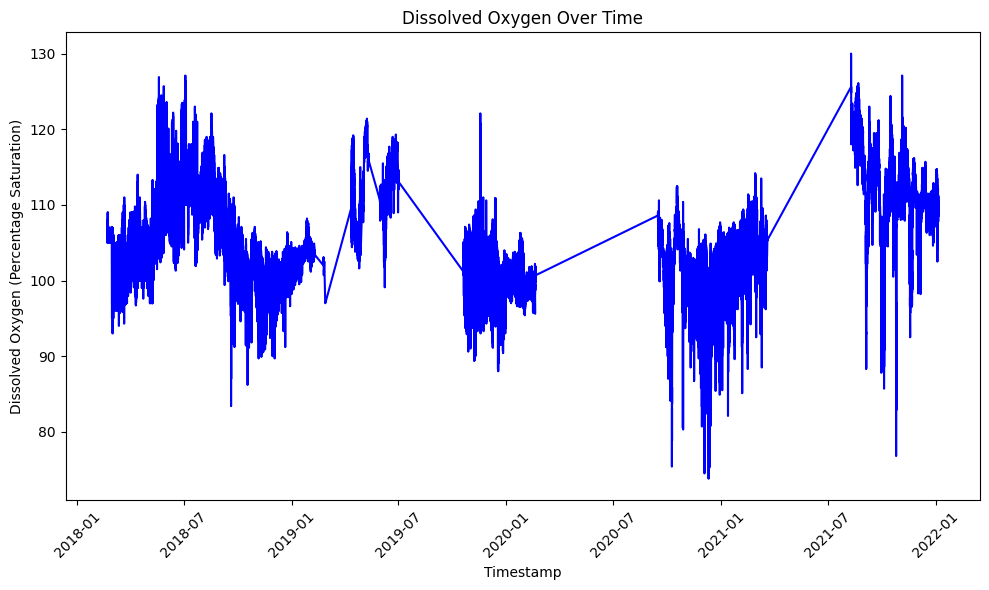

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(df_sorted['TIMESTAMP'], df_sorted['Dissolved Oxygen'] ,linestyle='-', color='blue')
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Dissolved Oxygen (Percentage Saturation)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [ ]:
df_sorted

VARIABLE,WATERBODY,STATION,LATITUDE,LONGITUDE,TIMESTAMP,SENSOR,Dissolved Oxygen,Temperature
2568752,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:01:00,aquaMeasure-670352,108.0,1.80
2568753,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:03:00,aquaMeasure-670353,106.0,1.70
2568755,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:11:00,aquaMeasure-670352,108.0,1.70
2568756,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:13:00,aquaMeasure-670353,106.0,1.70
2568760,St. Margarets Bay,Shut-In Island,44.554520,-63.95672,2018-02-20 19:21:00,aquaMeasure-670352,108.0,1.70
...,...,...,...,...,...,...,...,...
2356674,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:17:00,aquaMeasure-675016,108.7,3.58
2356676,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:27:00,aquaMeasure-675016,110.7,3.54
2356682,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:37:00,aquaMeasure-675016,109.7,3.54
2356688,Spry Bay,Spry Harbour,44.817926,-62.61883,2022-01-05 11:47:00,aquaMeasure-675016,110.3,3.52


In [ ]:
df_sorted['TIMESTAMP'] = pd.to_datetime(df_sorted['TIMESTAMP'])

# Set 'TIMESTAMP' as the DataFrame's index
df_sorted.set_index('TIMESTAMP', inplace=True)

# Now, proceed with the resampling as before

# Resample numerical features by mean
df_resampled_num = df_sorted.select_dtypes(include=['float64', 'int64']).resample('30T').mean()

# For categorical features, we'll first use ffill to fill gaps after resampling
df_resampled_cat = df_sorted.select_dtypes(exclude=['float64', 'int64']).resample('30T').first().ffill()

# Combine the resampled numerical and categorical dataframes
df_resampled = pd.concat([df_resampled_num, df_resampled_cat], axis=1)

# Reset index if needed to make 'time_idx' a regular column
df_resampled.reset_index(inplace=True)

# Optionally, if you need to create 'time_idx' as a sequential integer index
df_resampled['time_idx'] = range(len(df_resampled))

In [ ]:
df_resampled['target'] = df_resampled['Dissolved Oxygen'].shift(-48)
#-12 for 6 hours
#-24 for 12 hours
#-48 for 24 hours
#-96 for 48 hours

In [ ]:
# Drop rows with any NaN values
df_resampled_clean = df_resampled.dropna()

# Reset index if needed to make 'TIMESTAMP' a regular column
df_resampled_clean.reset_index(inplace=True)

# Optionally, if you need to create 'time_idx' as a sequential integer index
df_resampled_clean['time_idx'] = range(len(df_resampled_clean))

<ipython-input-19-99d91e88d570>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_clean['time_idx'] = range(len(df_resampled_clean))


In [ ]:
df_resampled_clean = df_resampled_clean.sort_values(by='TIMESTAMP')

In [ ]:
df_resampled_clean

VARIABLE,index,TIMESTAMP,LATITUDE,LONGITUDE,Dissolved Oxygen,Temperature,WATERBODY,STATION,SENSOR,time_idx,target
0,0,2018-02-20 19:00:00,44.554520,-63.95672,107.000000,1.716667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,0,105.750000
1,1,2018-02-20 19:30:00,44.554520,-63.95672,106.500000,1.650000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,1,105.000000
2,2,2018-02-20 20:00:00,44.554520,-63.95672,106.666667,1.616667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,2,105.750000
3,3,2018-02-20 20:30:00,44.554520,-63.95672,106.200000,1.540000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,3,105.333333
4,4,2018-02-20 21:00:00,44.554520,-63.95672,106.500000,1.516667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,4,107.000000
...,...,...,...,...,...,...,...,...,...,...,...
40120,67853,2022-01-04 09:30:00,44.817926,-62.61883,111.200000,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40120,110.466667
40121,67854,2022-01-04 10:00:00,44.817926,-62.61883,111.233333,3.286667,Spry Bay,Spry Harbour,aquaMeasure-675016,40121,110.566667
40122,67855,2022-01-04 10:30:00,44.817926,-62.61883,111.133333,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40122,109.833333
40123,67856,2022-01-04 11:00:00,44.817926,-62.61883,111.266667,3.246667,Spry Bay,Spry Harbour,aquaMeasure-675016,40123,109.300000


In [ ]:
def identify_gaps(dataframe, threshold_hours=6):
    # Assuming 'TIMESTAMP' is a column in the dataframe, we'll ensure it's in datetime format
    dataframe['TIMESTAMP'] = pd.to_datetime(dataframe['TIMESTAMP'])
    time_diff = dataframe['TIMESTAMP'].diff()
    gaps = time_diff > pd.Timedelta(hours=threshold_hours)
    return gaps

# Identify gaps
df_resampled_clean['gap'] = identify_gaps(df_resampled_clean)

# List to store the start and end datetimes of each gap
gap_ranges = []

# Identifying the start and end datetime of gap periods
for index, row in df_resampled_clean.iterrows():
    if row['gap']:
        start_gap_datetime = df_resampled_clean.iloc[max(0, index - 1)]['TIMESTAMP']
        end_gap_datetime = row['TIMESTAMP']
        gap_ranges.append((start_gap_datetime, end_gap_datetime))

In [ ]:
df_resampled = df_resampled_clean

In [ ]:
df_resampled['TIMESTAMP'] = pd.to_datetime(df_resampled['TIMESTAMP'])
df_resampled.set_index('TIMESTAMP', inplace=True)

In [ ]:
df_resampled['gap'] = False

# Adjust gap_ranges to include 24 hours before and after each gap
extended_gap_ranges = []
for start, end in gap_ranges:
    extended_start = start - pd.Timedelta(hours=24)
    extended_end = end + pd.Timedelta(hours=24)
    extended_gap_ranges.append((extended_start, extended_end))

# Mark resampled data as gap based on extended_gap_ranges
for start, end in extended_gap_ranges:
    df_resampled.loc[start:end, 'gap'] = True

# Now, filter out the rows marked as gaps
df_resampled = df_resampled[df_resampled['gap'] == False]

# Drop the 'gap' column as it's no longer needed after filtering
df_resampled = df_resampled.drop('gap', axis=1)

In [ ]:
df_resampled

VARIABLE,index,LATITUDE,LONGITUDE,Dissolved Oxygen,Temperature,WATERBODY,STATION,SENSOR,time_idx,target
TIMESTAMP,,,,,,,,,,
2018-02-20 19:00:00,0,44.554520,-63.95672,107.000000,1.716667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,0,105.750000
2018-02-20 19:30:00,1,44.554520,-63.95672,106.500000,1.650000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,1,105.000000
2018-02-20 20:00:00,2,44.554520,-63.95672,106.666667,1.616667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,2,105.750000
2018-02-20 20:30:00,3,44.554520,-63.95672,106.200000,1.540000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,3,105.333333
2018-02-20 21:00:00,4,44.554520,-63.95672,106.500000,1.516667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,4,107.000000
...,...,...,...,...,...,...,...,...,...,...
2022-01-04 09:30:00,67853,44.817926,-62.61883,111.200000,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40120,110.466667
2022-01-04 10:00:00,67854,44.817926,-62.61883,111.233333,3.286667,Spry Bay,Spry Harbour,aquaMeasure-675016,40121,110.566667
2022-01-04 10:30:00,67855,44.817926,-62.61883,111.133333,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,40122,109.833333


In [ ]:
df_resampled_clean = df_resampled

In [ ]:
df_resampled_clean.reset_index(inplace=True)

# Ensure TIMESTAMP is in datetime format
df_resampled_clean['TIMESTAMP'] = pd.to_datetime(df_resampled_clean['TIMESTAMP'])

# Create 'day', 'month', and 'hour' features from the TIMESTAMP column
df_resampled_clean['day'] = df_resampled_clean['TIMESTAMP'].dt.day.astype(str)
df_resampled_clean['month'] = df_resampled_clean['TIMESTAMP'].dt.month.astype(str)
df_resampled_clean['hour'] = df_resampled_clean['TIMESTAMP'].dt.hour.astype(str)

# Create or update 'time_idx' to be a sequential integer index starting from 0
df_resampled_clean['time_idx'] = range(len(df_resampled_clean))

#Data Preperation

In [ ]:
df_resampled_clean

VARIABLE,TIMESTAMP,index,LATITUDE,LONGITUDE,Dissolved Oxygen,Temperature,WATERBODY,STATION,SENSOR,time_idx,target,day,month,hour
0,2018-02-20 19:00:00,0,44.554520,-63.95672,107.000000,1.716667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,0,105.750000,20,2,19
1,2018-02-20 19:30:00,1,44.554520,-63.95672,106.500000,1.650000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,1,105.000000,20,2,19
2,2018-02-20 20:00:00,2,44.554520,-63.95672,106.666667,1.616667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,2,105.750000,20,2,20
3,2018-02-20 20:30:00,3,44.554520,-63.95672,106.200000,1.540000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,3,105.333333,20,2,20
4,2018-02-20 21:00:00,4,44.554520,-63.95672,106.500000,1.516667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,4,107.000000,20,2,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,2022-01-04 09:30:00,67853,44.817926,-62.61883,111.200000,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,39403,110.466667,4,1,9
39404,2022-01-04 10:00:00,67854,44.817926,-62.61883,111.233333,3.286667,Spry Bay,Spry Harbour,aquaMeasure-675016,39404,110.566667,4,1,10
39405,2022-01-04 10:30:00,67855,44.817926,-62.61883,111.133333,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,39405,109.833333,4,1,10
39406,2022-01-04 11:00:00,67856,44.817926,-62.61883,111.266667,3.246667,Spry Bay,Spry Harbour,aquaMeasure-675016,39406,109.300000,4,1,11


In [ ]:
!pip install pytorch-forecasting
!pip install pytorch-lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB

#Modeling

Read this -> https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

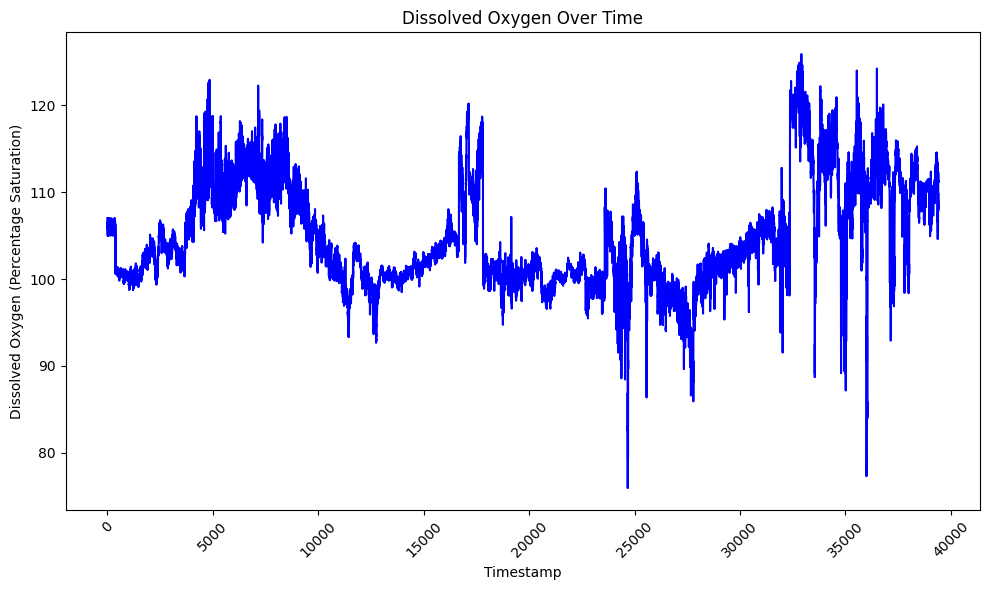

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.plot(df_resampled_clean['time_idx'], df_resampled_clean['Dissolved Oxygen'] ,linestyle='-', color='blue')
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Dissolved Oxygen (Percentage Saturation)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [ ]:
data = df_resampled_clean

In [ ]:
data

VARIABLE,TIMESTAMP,index,LATITUDE,LONGITUDE,Dissolved Oxygen,Temperature,WATERBODY,STATION,SENSOR,time_idx,target,day,month,hour
0,2018-02-20 19:00:00,0,44.554520,-63.95672,107.000000,1.716667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,0,105.750000,20,2,19
1,2018-02-20 19:30:00,1,44.554520,-63.95672,106.500000,1.650000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,1,105.000000,20,2,19
2,2018-02-20 20:00:00,2,44.554520,-63.95672,106.666667,1.616667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,2,105.750000,20,2,20
3,2018-02-20 20:30:00,3,44.554520,-63.95672,106.200000,1.540000,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,3,105.333333,20,2,20
4,2018-02-20 21:00:00,4,44.554520,-63.95672,106.500000,1.516667,St. Margarets Bay,Shut-In Island,aquaMeasure-670352,4,107.000000,20,2,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,2022-01-04 09:30:00,67853,44.817926,-62.61883,111.200000,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,39403,110.466667,4,1,9
39404,2022-01-04 10:00:00,67854,44.817926,-62.61883,111.233333,3.286667,Spry Bay,Spry Harbour,aquaMeasure-675016,39404,110.566667,4,1,10
39405,2022-01-04 10:30:00,67855,44.817926,-62.61883,111.133333,3.266667,Spry Bay,Spry Harbour,aquaMeasure-675016,39405,109.833333,4,1,10
39406,2022-01-04 11:00:00,67856,44.817926,-62.61883,111.266667,3.246667,Spry Bay,Spry Harbour,aquaMeasure-675016,39406,109.300000,4,1,11


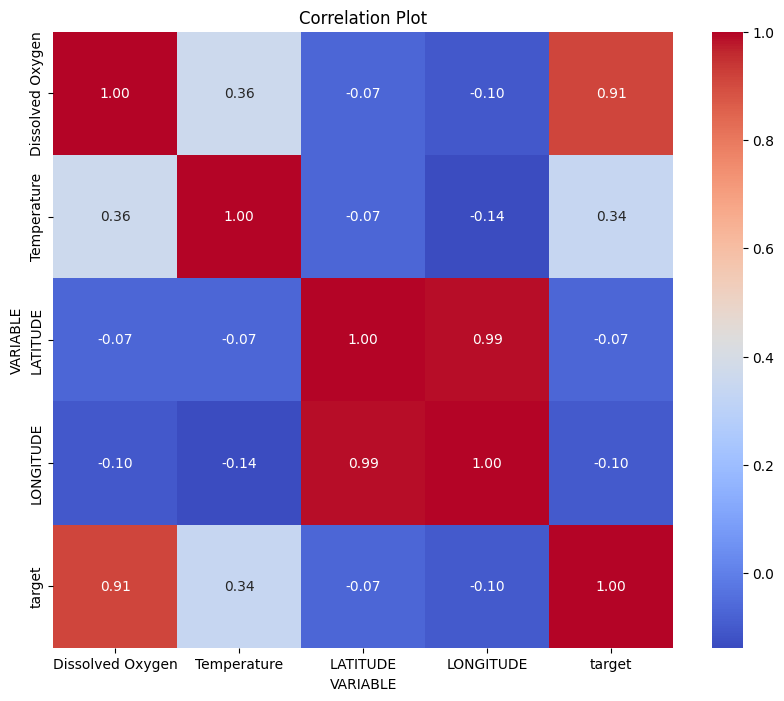

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is stored in a variable called 'data'
df = data

# List of variables to include in correlation analysis
selected_vars = ['Dissolved Oxygen', 'Temperature', 'LATITUDE', 'LONGITUDE', 'target']

# Select only the selected variables from the DataFrame
numeric_cols = df[selected_vars]

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Plot')
plt.show()


In [ ]:
max_prediction_length = 96
max_encoder_length = 96
batch_size = 128  # Adjust based on your system's capabilities

total_rows = len(data)
train_end = int(total_rows * 0.7)

# Split the dataset
df = data.iloc[:train_end]

testing_data = data.iloc[train_end:]

In [ ]:
# Calculate the 80% cutoff point
cutoff_point = df['time_idx'].max() * 0.80

# Set the training cutoff
training_cutoff = int(cutoff_point)

In [ ]:

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["WATERBODY", "STATION","SENSOR"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["day", "month","hour"],
    time_varying_known_reals=["time_idx","Dissolved Oxygen"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "LATITUDE",
        "LONGITUDE",
        "Temperature",
    ],
    categorical_encoders={
        'WATERBODY': NaNLabelEncoder(add_nan=True),
        'STATION': NaNLabelEncoder(add_nan=True),
        'SENSOR': NaNLabelEncoder(add_nan=True),
        },
    target_normalizer=GroupNormalizer(
        groups=["WATERBODY", "STATION","SENSOR"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# For validation and testing sets, use from_dataset method to ensure they have the same configuration as the training set
# validation = TimeSeriesDataSet.from_dataset(training, validation_data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, testing_data, predict=True, stop_randomization=True)
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)


# Create DataLoaders
batch_size = 32  # Adjust this according to your needs
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# max_prediction_length = 96
# max_encoder_length = 96
# training_cutoff = data["time_idx"].max() - max_prediction_length

# training = TimeSeriesDataSet(
#     data[lambda x: x.time_idx <= training_cutoff],
#     time_idx="time_idx",
#     target="Dissolved Oxygen",
#     group_ids=["WATERBODY", "STATION","SENSOR"],
#     min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
#     max_encoder_length=max_encoder_length,
#     min_prediction_length=1,
#     max_prediction_length=max_prediction_length,
#     time_varying_known_categoricals=["day", "month","hour"],
#     time_varying_known_reals=["time_idx"],
#     time_varying_unknown_categoricals=[],
#     time_varying_unknown_reals=[
#         "LATITUDE",
#         "LONGITUDE",
#         "Temperature",
#     ],
#     target_normalizer=GroupNormalizer(
#         groups=["WATERBODY", "STATION","SENSOR"], transformation="softplus"
#     ),
#     categorical_encoders={
#         'WATERBODY': NaNLabelEncoder(add_nan=True),
#         'STATION': NaNLabelEncoder(add_nan=True),
#         'SENSOR': NaNLabelEncoder(add_nan=True),
#         },
#     add_relative_time_idx=True,
#     add_target_scales=True,
#     add_encoder_length=True,
#     allow_missing_timesteps=True
# )

# # create validation set (predict=True) which means to predict the last max_prediction_length points in time
# # for each series
# validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# # create dataloaders for model
# batch_size = 128  # set this between 32 to 128
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
!pip install optuna==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: optuna
    Found existing installation: optuna 3.6.1
    Uninstalling optuna-3.6.1:
      Successfully uninstalled optuna-3.6.1


In [ ]:
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=50,
#     max_epochs=5,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )


#STUDY

In [ ]:
#add study =

In [ ]:
# import pickle

# with open('/content/study_results.pkl', 'rb') as f:
#     study = pickle.load(f)


EOFError: Ran out of input

In [ ]:
study.best_trial

In [ ]:
# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=0, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
# quantiles =  [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=study.best_trial.params['learning_rate'],
#     hidden_size=study.best_trial.params['hidden_size'],
#     attention_head_size=study.best_trial.params['attention_head_size'],
#     dropout=study.best_trial.params['dropout'],
#     hidden_continuous_size=study.best_trial.params['hidden_continuous_size'],
#     loss=QuantileLoss(quantiles=quantiles),
#     optimizer="Ranger",
#     reduce_on_plateau_patience=500,
# )

# trainer = pl.Trainer(
#     max_epochs=50,
#     accelerator="gpu",
#     enable_model_summary=True,
#     gradient_clip_val=study.best_trial.params['gradient_clip_val'],
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
# )

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 9.8k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.8912509381337452
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.8912509381337452
INFO: Restoring states from the checkpoint path at /content/.lr_find_68747e49-f5bc-4581-a70b-11da8162167e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_68747e49-f5bc-4581-a70b-11da8162167e.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_68747e49-f5bc-4581-a70b-11da8162167e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_68747e49-f5bc-4581-a70b-11da8162167e.ckpt


suggested learning rate: 0.8912509381337452


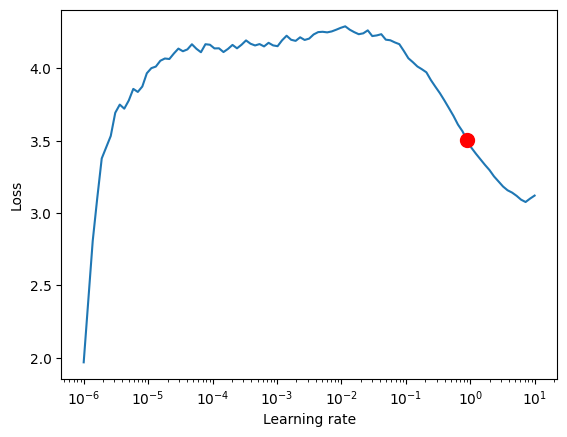

In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=0, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=64,
    attention_head_size=32,
    dropout=0.1,
    hidden_continuous_size=64,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 416.9k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 629   
3  | prescalers                         | ModuleDict                      | 1.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 51.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 106 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 53.1 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


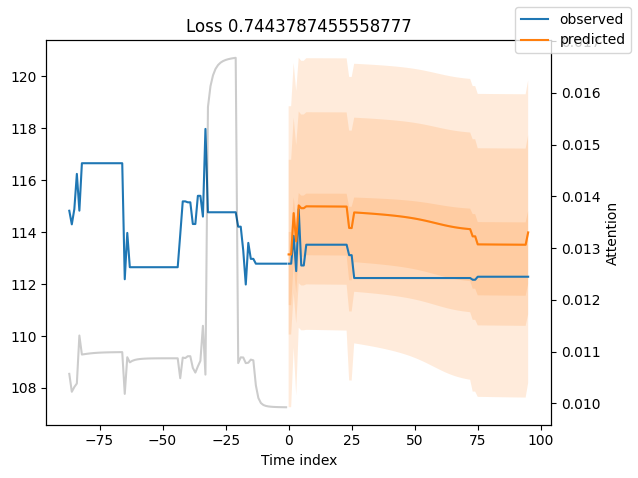

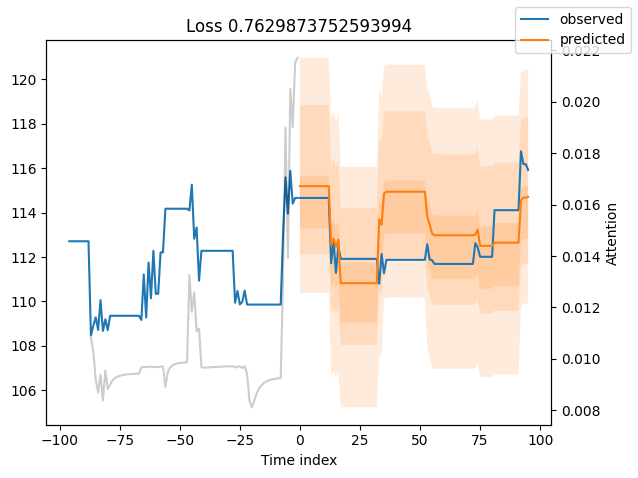

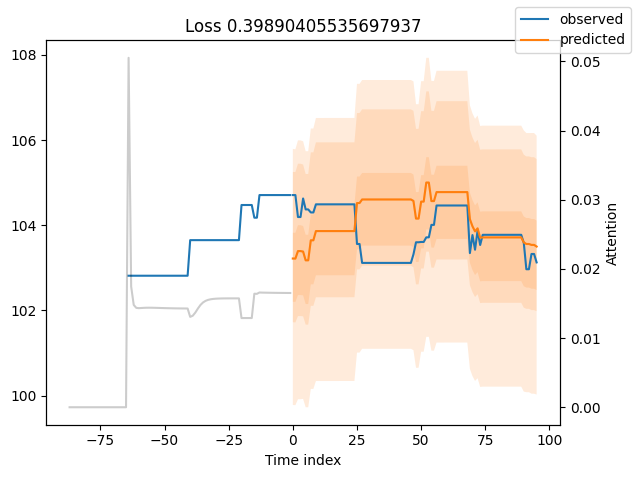

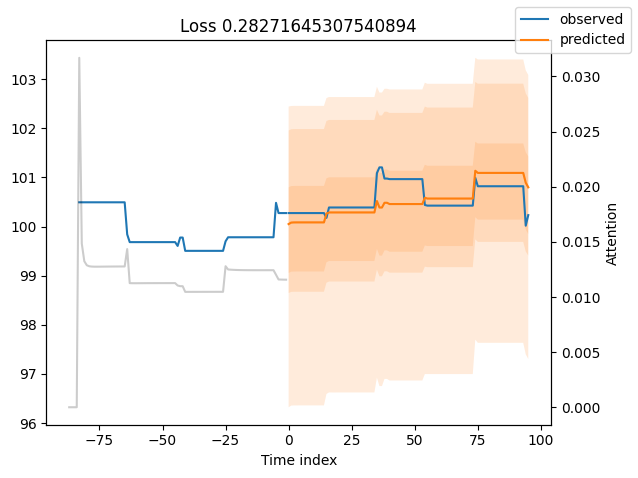

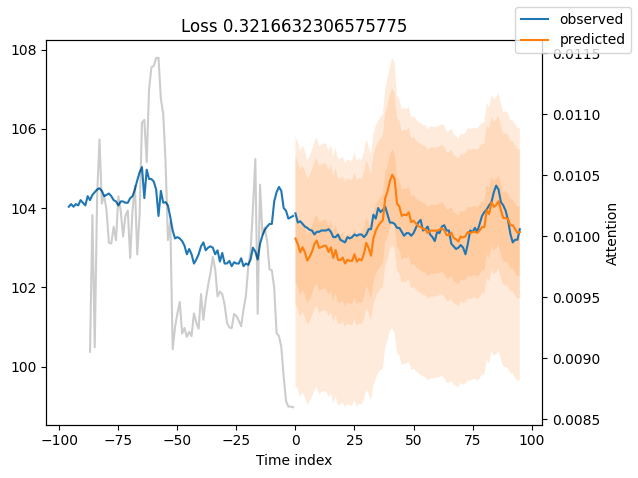

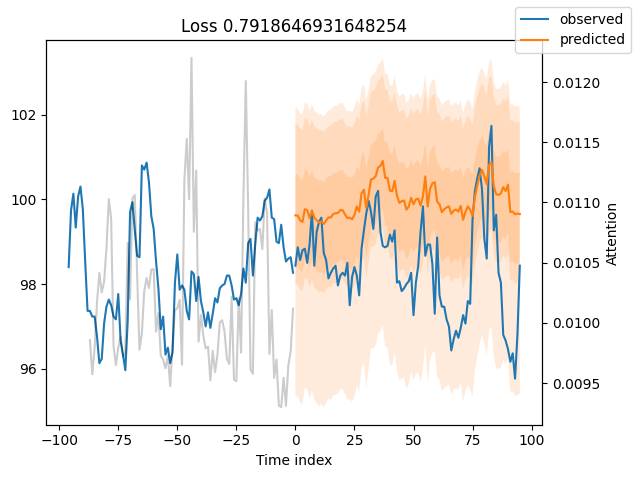

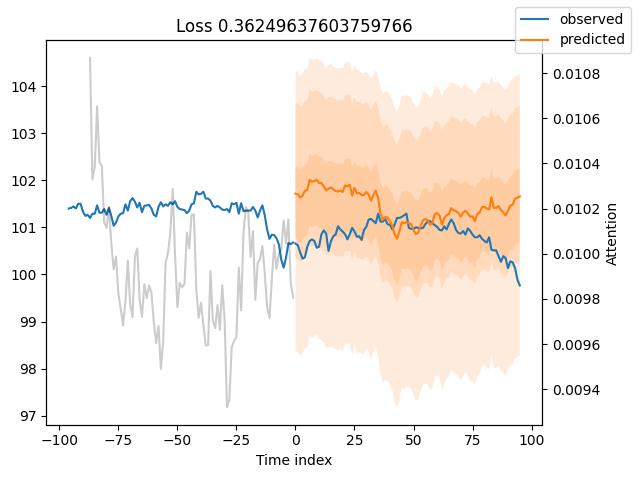

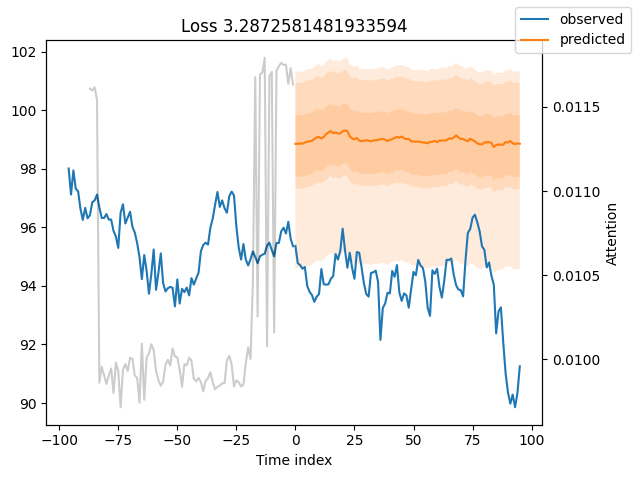

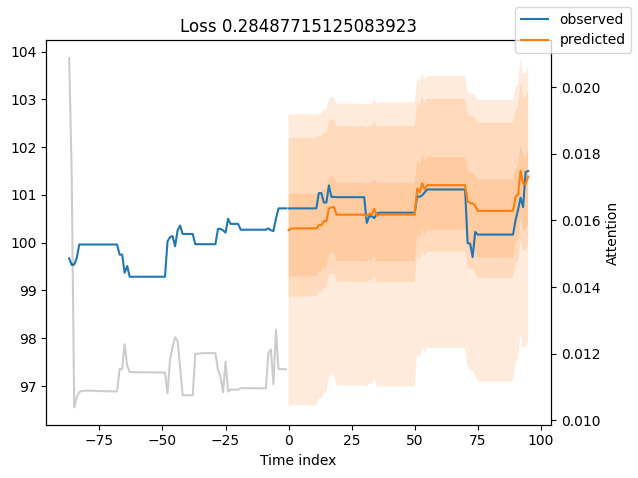

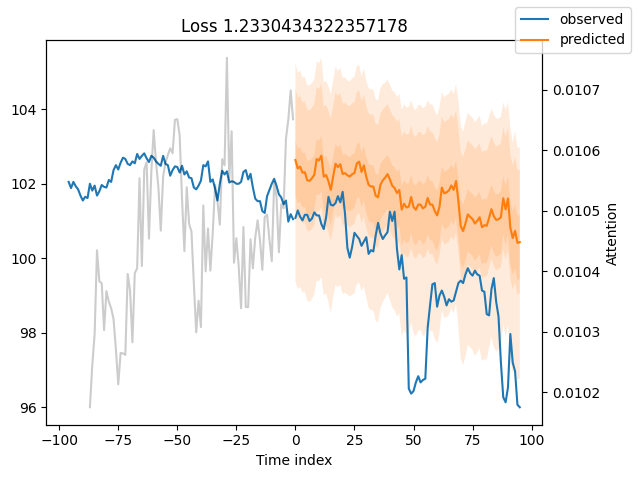

In [ ]:
for idx in range(10):  # plot 10 examples
    tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x425 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

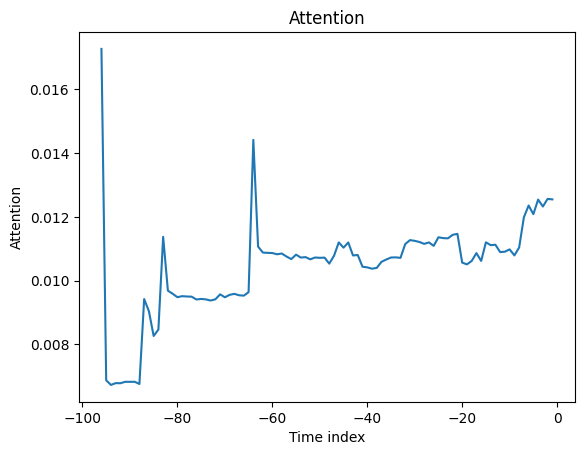

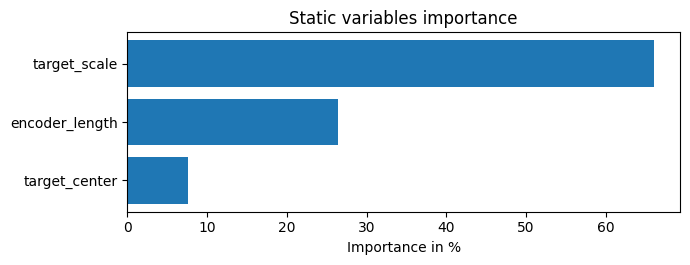

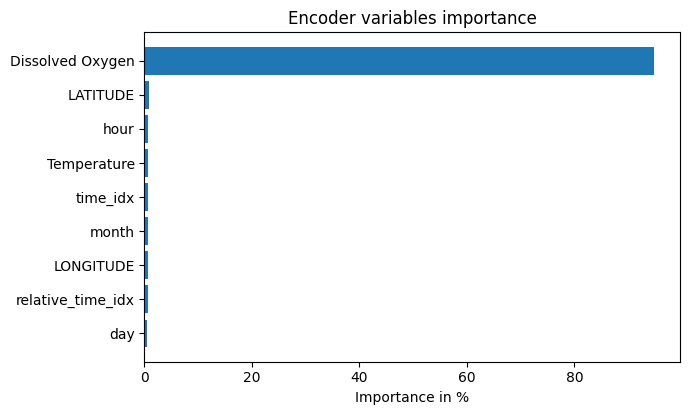

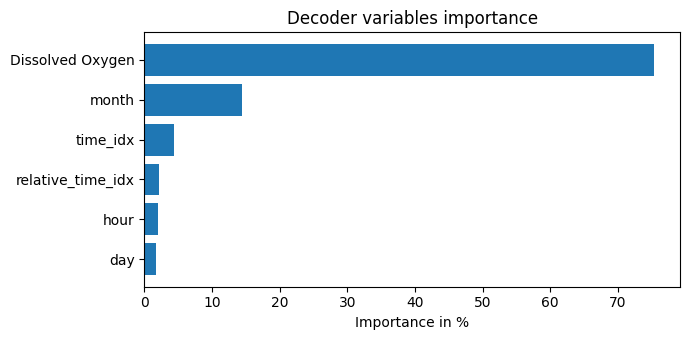

In [ ]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [ ]:
#rmse =

Training the TFT Model

#Evaluation

Model Evaluation

In [ ]:
train_end = int(total_rows * 0.8)


testing_data = data.iloc[train_end:]

In [ ]:
test = TimeSeriesDataSet(
    testing_data,
    time_idx="time_idx",
    target="target",
    group_ids=["WATERBODY", "STATION","SENSOR"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["day", "month","hour"],
    time_varying_known_reals=["time_idx","Dissolved Oxygen"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "LATITUDE",
        "LONGITUDE",
        "Temperature"
    ],
    categorical_encoders={
        'WATERBODY': NaNLabelEncoder(add_nan=True),
        'STATION': NaNLabelEncoder(add_nan=True),
        'SENSOR': NaNLabelEncoder(add_nan=True),
        },
    target_normalizer=GroupNormalizer(
        groups=["WATERBODY", "STATION","SENSOR"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

In [ ]:
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
predictions = tft.predict(test_dataloader, return_x=True, mode = "raw")


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 12.38 MiB is free. Process 14449 has 15.76 GiB memory in use. Of the allocated memory 15.29 GiB is allocated by PyTorch, and 90.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

NameError: name 'matched_quantile_values' is not defined

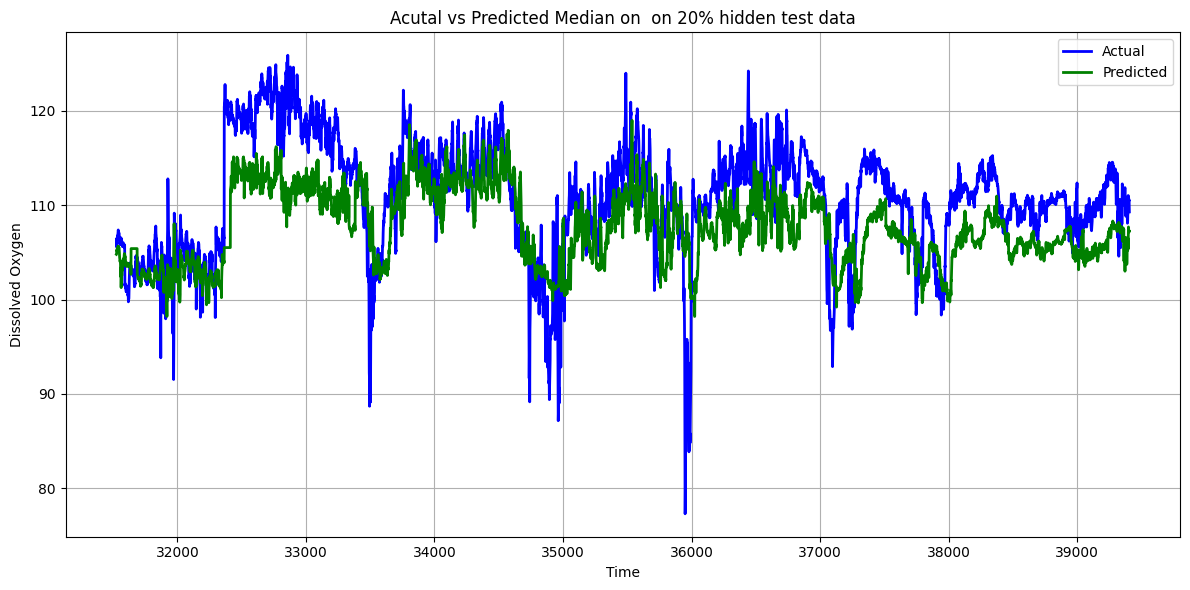

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the predicted values and time indices
predicted_values = predictions.output[0][:, :, 6].cpu().numpy().flatten()#predictions.output.cpu().numpy().flatten()
# predicted_values = predictions.output[0][:, 0, :].cpu().numpy().flatten()#predictions.output.cpu().numpy().flatten()



time_indices = predictions.x['decoder_time_idx'].cpu().numpy().flatten()

# Your data (sample)
data_time_idx = df_actual.time_idx



# Create a dictionary to map time_idx to predicted_values
time_idx_to_predicted_value = dict(zip(time_indices, predicted_values))

# Match the values
matched_predicted_values = [time_idx_to_predicted_value[idx] for idx in data_time_idx if idx in time_idx_to_predicted_value]


# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))

plt.plot(df_test.index[:len(matched_predicted_values)-1], df_test.target[:len(matched_predicted_values)-1] , label='Actual', color='blue', linewidth=2)
plt.plot(df_test.index[:len(matched_predicted_values)-1], matched_predicted_values[:len(matched_predicted_values)-1], label='Predicted', color='green', linewidth=2)


plt.title('Acutal vs Predicted Median on  on 20% hidden test data')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(df_test.target[:len(matched_predicted_values)], matched_predicted_values)
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 4.382054962168528


#Deployment

Model Inference, Writing code for the use case scenario i.e single use case prediction

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Extract the predicted values and time indices
predicted_values = predictions.output[0][:, :, 6].cpu().numpy().flatten()  # predictions.output.cpu().numpy().flatten()
time_indices = predictions.x['decoder_time_idx'].cpu().numpy().flatten()

# Your data (sample)
data_time_idx = df_actual.time_idx

# Create a dictionary to map time_idx to predicted_values
time_idx_to_predicted_value = dict(zip(time_indices, predicted_values))

# Match the values
matched_predicted_values = [time_idx_to_predicted_value[idx] for idx in data_time_idx if idx in time_idx_to_predicted_value]

# Create traces for actual and predicted data
actual_trace = go.Scatter(x=df_test.index[:len(matched_predicted_values)-1],
                          y=df_test.target[:len(matched_predicted_values)-1],
                          mode='lines',
                          name='Actual',
                          line=dict(color='blue', width=2))

predicted_trace = go.Scatter(x=df_test.index[:len(matched_predicted_values)-1],
                             y=matched_predicted_values[:len(matched_predicted_values)-1],
                             mode='lines',
                             name='Predicted',
                             line=dict(color='green', width=2))

# Create the figure
fig = go.Figure([actual_trace, predicted_trace])

# Update layout
fig.update_layout(title='Actual vs Predicted Median on 20% hidden test data',
                  xaxis_title='Time',
                  yaxis_title='Dissolved Oxygen',
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
                  margin=dict(l=0, r=0, t=50, b=0),
                  template='plotly_white')

# Show the plot
fig.show()


In [ ]:
!pip install nbconvert
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo

In [ ]:
!jupyter nbconvert --to pdf PDS Final Project - DOC_NS.ipynb
from google.colab import drive
drive.mount("/content/drive")

[NbConvertApp] WARNING | pattern 'PDS' matched no files
[NbConvertApp] WARNING | pattern 'Final' matched no files
[NbConvertApp] WARNING | pattern 'Project' matched no files
[NbConvertApp] WARNING | pattern '-' matched no files
[NbConvertApp] WARNING | pattern 'DOC_NS.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--g